<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёты-и-добавление-результатов-в-таблицу" data-toc-modified-id="Расчёты-и-добавление-результатов-в-таблицу-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчёты и добавление результатов в таблицу</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры для создания автоматизированной системы отслеживания аномалий и мошеннической деятельности. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [8]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')
#print(data.head(5))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Каждый столбец содержит в себе информацию о параметре, характеризующем квартиру из архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. По результатам первичного изучения полученных данных было обнаружено несколько проблем:
1. некоторые типы данных распознаны неверно: параметр "является ли недвижимость апартаментами" был распознан как object, хотя должен был быть типа bool (Правда/Ложь), параметр "дата публикации" был распознан как object, хотя должен был быть datetime. Также параметры "число парков/прудов в радиусе 3 км" были распознаны как float, должны быть int и т.д.
2. были обнаружены множество пропущенных значений в колонках ceiling_height,floors_total, balcony  и т.д., о которых будет более подробно сказано ниже.

Следующий шаг будет направлен на подробное изучение и обработку пропущенных данных.

## Предобработка данных

Второй шаг направлен на обработку пропущенных значений. В первую очередь прокомментируем основные столбцы, в которых есть наибольшее количеств пропусков:
1. столбец 'is_apartment' имеет большее количество пропусков (88.3%) и представляет собой булев массив - можно предположить, что если информации по тому, что квартира является апартаменатми, нет, то квартира ими и не является - иначе владелец бы указал - такие пропуски имеет смысл заполнять, следуя простой логике;
2. столбцы 'parks_nearest' и 'ponds_nearest', 'airports_nearest' и 'cityCenters_nearest' (23.3% - 65,9% пропущенных значений) требуют дополнительного анализа и, скорее всего, могут быть заполнены исходя из данных о населенном пункте;
3. столбец 'balcony' содержит 48,6% пропущенных значений и может быть заполнен исходя из житейской логики - если наличие балкона не указано, скорее всего, его нет;
4. столбец 'ceiling_height'имеет 38,8% пропущенных значений и может быть заполнен исходя из медианного значения, так как существуют общепринятые нормы, согласно которым высота потолка не может быть ниже 2.4 м, а максимальная высота, как правило, не превышает 3.6 м (округлим до 4 м, предположив, что мы о говорим о сталинских домах);
5. столбец 'kitchen_area'(9.61%) может быть заполнен исходя из медианного значения площади квартиры;
6. столбец 'living_area'(8.03% пропущенныхзначений) заполним медианным значением по количеству комнат;

Пропущенные значения в оставшихся столбцах либо полностью отсутсвуют, либо их процент незначителен - это значит, что такими значениями можно пренебречь и, соответствнно, они могут быть удалены.

In [9]:
data_count = data.isna().sum().sort_values(ascending = False)
data_percent = (data_count /len(data))* 100
data_missing = pd.DataFrame([data_count, data_percent]).T
data_missing.columns =['number', 'percent']
data_missing.round(2)

,number,percent
is_apartment,20924.0,88.29
parks_nearest,15620.0,65.91
ponds_nearest,14589.0,61.56
balcony,11519.0,48.61
ceiling_height,9195.0,38.80
airports_nearest,5542.0,23.38
cityCenters_nearest,5519.0,23.29
parks_around3000,5518.0,23.28
ponds_around3000,5518.0,23.28
days_exposition,3181.0,13.42


В первую очередь разберемся со столбцом 'is_apartment' - так как апартаменты это достаточно специфический тип недвижимости, можно предположить, что владельцы указывают эту особенности квартиры, если она есть. Заменим пропущенные значения в данном столбце на False. Тип столбца - булев, что маркирует True наличие апартаментов и False их отсутствие. 

In [10]:
#data['is_apartment'].value_counts()
print('Количество пропусков в колонке "is_apartment" до заполнения:', data['is_apartment'].isna().sum())
data['is_apartment'] = data['is_apartment'].fillna(0)
print('Количество пропусков в колонке "is_apartment" после заполнения:', data['is_apartment'].isna().sum())

Количество пропусков в колонке "is_apartment" до заполнения: 20924
Количество пропусков в колонке "is_apartment" после заполнения: 0


Обрабатывая числовой столбец 'balcony', будем также следовать житейской логике: если наличие балкона не указано, скорее всего, он отсутствует. Соответственно, заполним такие пробелы обычным нулем.

In [11]:
#data['balcony'].value_counts()
print('Количество пропусков в колонке "balcony" до заполнения:', data['balcony'].isna().sum())
data['balcony'] = data['balcony'].fillna(0)
print('Количество пропусков в колонке "balcony" после заполнения:', data['balcony'].isna().sum())

Количество пропусков в колонке "balcony" до заполнения: 11519
Количество пропусков в колонке "balcony" после заполнения: 0


Следующий шаг предобработки - анализ столбца 'ceiling_height': при анализе уникальных значений столбца были выявлены некоторые странности: у нас есть максимальное значение - 100.0, которое выступает выбросом - потолок не может быть 100 м, кроме того, стоит сказать, что стандартное отклонение значительно отклоняется от среднего значения, что также свидетельсвует о выбросах и аномальных значениях.

In [12]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Построим гистограму для анализа данных - можно увидеть, что из 14504 значений большая часть находится рамках условно "хороших" значений (от 2.5 до 4 м), однако обнаружено 91 "плохое" значение, выходящее за эти рамки. Для того, чтобы посчитать "неискаженную" медиану в дальнейшем, необходимо удалить эти аномальные значения.

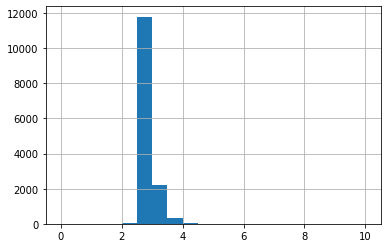

In [13]:
len(data.query('ceiling_height < 2.3 or  ceiling_height > 4.0')) # таких "фальшивых" потолков у нас 91
data['ceiling_height'].hist(bins = 20, range = (0.0, 10.0))

In [14]:
wrong_data = data.query('ceiling_height < 2.3 or  ceiling_height > 4.0').index
data.drop(wrong_data, inplace = True) #удалим "аномальные" потолки
#data['ceiling_height'].value_counts() # проверим правильность удаления
groups_ceiling = data.groupby(['floor'])['ceiling_height'].transform('median')
data['ceiling_height'] = data['ceiling_height'].fillna(groups_ceiling) # заполним пропущенные значения группировкой по этажам
data[data['ceiling_height'].isnull()] # проверим результативность операции
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) # осталось 4 пропуска - заполним их медианой по столбцу
print('Количество пропусков в колонке "ceiling_height" после заполнения:', data['ceiling_height'].isna().sum())

Количество пропусков в колонке "ceiling_height" после заполнения: 0


Далее разберемся со столбцом 'living_area' - заполним пропущенные значения медианой с группировкой по столбцу "кол-во комнат", так как предполагаем, что чем больше комнат, тем больше площадь квартиры.

In [15]:
#data['living_area'].value_counts()
print('Количество пропусков в колонке "living_area" до заполнения:', data['living_area'].isna().sum())
groups_living_area = data.groupby(['rooms'])['living_area'].transform('median')
data['living_area'] = data['living_area'].fillna(groups_living_area)
print('Количество пропусков в колонке "living_area" после заполнения:', data['living_area'].isna().sum())

Количество пропусков в колонке "living_area" до заполнения: 1895
Количество пропусков в колонке "living_area" после заполнения: 0


Далее разберемся со столбцом 'kitchen_area' - заполним пропущенные значения медианой с группировкой по столбцу "площадь квартиры", так как предполагаем, что чем больше общая площадь, тем больше площадь кухни.

In [16]:
#data['kitchen_area'].value_counts()
print('Количество пропусков в колонке "kitchen_area" до заполнения:', data['kitchen_area'].isna().sum())
groups_kitchen_area = data.groupby(['living_area'])['kitchen_area'].transform('median')
data['kitchen_area'] = data['kitchen_area'].fillna(groups_kitchen_area)
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median()) # осталось 64 пропуска
print('Количество пропусков в колонке "kitchen_area" после заполнения:', data['kitchen_area'].isna().sum())

Количество пропусков в колонке "kitchen_area" до заполнения: 2263
Количество пропусков в колонке "kitchen_area" после заполнения: 0


Поработаем со столбцом 'locality_name'- переведем все слова в нижний регистр и заменим букву "ё" н "е", чтобы избавиться от проблемы "посёлка/поселка" и сократить список с 363 до 329 значений. Больше пропущенные значения мы заполнять не будем, так как реконструировать эту информацию мы не можем. 

In [17]:
data['locality_name'].unique().tolist()#363 уникальных значения
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
data['locality_name'].value_counts()

санкт-петербург           15659
поселок мурино              554
поселок шушары              440
всеволожск                  396
пушкин                      368
                          ...  
деревня меньково              1
поселок петро-славянка        1
поселок плоское               1
поселок почап                 1
село никольское               1
Name: locality_name, Length: 329, dtype: int64

Пропуски в столбце "floors_total" ввиду их небольшого количества (менее 1% или 86 наблюдений) будут нами заменены на 0.

In [18]:
print('Количество пропусков в колонке "floors_total" до предобработки:', data['floors_total'].isna().sum())
data = data.dropna(subset=['floors_total'])
print('Количество пропусков в колонке "floors_total" после удаления:', data['floors_total'].isna().sum())

Количество пропусков в колонке "floors_total" до предобработки: 86
Количество пропусков в колонке "floors_total" после удаления: 0


Стобцы 'parks_nearest' и 'ponds_nearest' не могут быть полностью нами проигнорированы, так как процент пропущенных значений больше 60%. В связи с этим заполним эти значения исходя из медианы по населенному пункту, признавая такой заполнение достаточно условным в силу того, что разные районы одного города могу иметь совершенно разные значения (если мы говорим о крупном городе).

In [27]:
#data['parks_nearest'].value_counts()
print('Количество пропусков в колонке "parks_nearest" до заполнения:', data['parks_nearest'].isna().sum())
groups_parks_nearest = data.groupby(['locality_name'])['parks_nearest'].transform('median')
data['parks_nearest'] = data['parks_nearest'].fillna(groups_parks_nearest)# осталось 6006 пропусков
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median()) 
print('Количество пропусков в колонке "parks_nearest" после заполнения:', data['parks_nearest'].isna().sum()) #заполним медианой по столбцу

Количество пропусков в колонке "parks_nearest" до заполнения: 0
Количество пропусков в колонке "parks_nearest" после заполнения: 0


In [26]:
#data['ponds_nearest'].value_counts()
print('Количество пропусков в колонке "ponds_nearest" до заполнения:', data['ponds_nearest'].isna().sum())
groups_ponds_nearest = data.groupby(['locality_name'])['ponds_nearest'].transform('median')
data['ponds_nearest'] = data['ponds_nearest'].fillna(groups_ponds_nearest)# осталось 6006 пропусков
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median()) 
print('Количество пропусков в колонке "ponds_nearest" после заполнения:', data['ponds_nearest'].isna().sum()) #заполним медианой по столбцу

Количество пропусков в колонке "ponds_nearest" до заполнения: 0
Количество пропусков в колонке "ponds_nearest" после заполнения: 0


In [25]:
#data['cityCenters_nearest'].value_counts()
print('Количество пропусков в колонке "cityCenters_nearest" до заполнения:', data['cityCenters_nearest'].isna().sum())
groups_cityCenters_nearest = data.groupby(['locality_name'])['cityCenters_nearest'].transform('median')
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(groups_cityCenters_nearest)# осталось 6006 пропусков
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median()) 
print('Количество пропусков в колонке "cityCenters_nearest" после заполнения:', data['cityCenters_nearest'].isna().sum()) #заполним медианой по столбцу

Количество пропусков в колонке "cityCenters_nearest" до заполнения: 0
Количество пропусков в колонке "cityCenters_nearest" после заполнения: 0


In [23]:
#data['airports_nearest'].value_counts()
print('Количество пропусков в колонке "airports_nearest" до заполнения:', data['airports_nearest'].isna().sum())
groups_airports_nearest = data.groupby(['locality_name'])['airports_nearest'].transform('median')
data['airports_nearest'] = data['airports_nearest'].fillna(groups_airports_nearest)# осталось 6006 пропусков
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median()) 
print('Количество пропусков в колонке "airports_nearest" после заполнения:', data['airports_nearest'].isna().sum()) #заполним медианой по столбцу

Количество пропусков в колонке "airports_nearest" до заполнения: 5504
Количество пропусков в колонке "airports_nearest" после заполнения: 0


Большинство пропущенных значений нами было заполнено, некоторые пропущенные значения нами были пропущены - например, days_exposition, где мы не можем реконструировать данные и ponds/parks_around3000, где группировка по населенному пункту также кажется неинформативной и "привязанной".

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23522 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23522 non-null int64
last_price              23522 non-null float64
total_area              23522 non-null float64
first_day_exposition    23522 non-null object
rooms                   23522 non-null int64
ceiling_height          23522 non-null float64
floors_total            23522 non-null float64
living_area             23522 non-null float64
floor                   23522 non-null int64
is_apartment            23522 non-null object
studio                  23522 non-null bool
open_plan               23522 non-null bool
kitchen_area            23522 non-null float64
balcony                 23522 non-null float64
locality_name           23474 non-null object
airports_nearest        23522 non-null float64
cityCenters_nearest     23522 non-null float64
parks_around3000        18039 non-null float64
parks_nearest           23522 non-null float64
ponds_around3

Следующим шагом предобработки будет приведение типов данных к правильным. В первую очередь приведем столбец first_day_exposition от текстового типа к типу даты, без времени.

In [17]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['first_day_exposition'].head(5)

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

Переведем тип данных 'balcony', 'floors_total', 'last_price', 'days_exposition' от типа float64 к типу int, так как нам нужны целочисленные значения.

In [18]:
data['balcony'] = data['balcony'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['last_price'] = data['last_price'].astype('int')
data['total_area'] = data['total_area'].astype('int')
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23608 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23608 non-null int64
last_price              23608 non-null int64
total_area              23608 non-null int64
first_day_exposition    23608 non-null datetime64[ns]
rooms                   23608 non-null int64
ceiling_height          23608 non-null float64
floors_total            23608 non-null int64
living_area             23608 non-null float64
floor                   23608 non-null int64
is_apartment            23608 non-null bool
studio                  23608 non-null bool
open_plan               23608 non-null bool
kitchen_area            23608 non-null float64
balcony                 23608 non-null int64
locality_name           23559 non-null object
airports_nearest        23608 non-null float64
cityCenters_nearest     23608 non-null float64
parks_around3000        18115 non-null float64
parks_nearest           23608 non-null float64
ponds_around300

### Вывод

По итогам первого этапа исследования - предобработки данных были предприняты следующие шаги:
   1. обнаружены и обработаны пропущенные значения в 9 столбцах с использованием заполнения методом fillna() и группировкой по столбцу с заполнением медианой методом transform;
   2. изменены искажения типов данных - текстовый формат в дате выставления квартиры заменен на формат даты, а часть значений (число балконов, этажей, пр.) приведена от вещественного к целочисленному типу, что существенно упростило восприятие данных.
  
Следующим шагом исследования выступает расчет необходимых параметров квартиры.

## Расчёты и добавление результатов в таблицу

В первую очередь посчитаем цену квадратного метра исходя из следующих параметров - цены на квартиру и общей площади квартиры.

In [20]:
data['price_per_meter'] = data['last_price'] / data['total_area']
data['price_per_meter'] = data['price_per_meter'].astype('int')
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0,120370
1,7,3350000,40,2018-12-04,1,2.60,11,18.6,1,False,...,2,поселок шушары,12817.0,18603.0,0.0,460.0,0.0,584.5,81,83750
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785
3,0,64900000,159,2015-07-24,3,2.60,14,45.0,9,False,...,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000


Посчитаем и добавим в таблицу день недели, месяц и год публикации объявления.

In [21]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,0,120370,3,3,2019
1,7,3350000,40,2018-12-04,1,2.60,11,18.6,1,False,...,18603.0,0.0,460.0,0.0,584.5,81,83750,1,12,2018
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,13933.0,1.0,90.0,2.0,574.0,558,92785,3,8,2015
3,0,64900000,159,2015-07-24,3,2.60,14,45.0,9,False,...,6800.0,2.0,84.0,3.0,234.0,424,408176,4,7,2015
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121,100000,1,6,2018


Далее добавим этаж квартиры — первый, последний, другой

In [22]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['floor_category'] = data.apply(floor_type, axis=1)
data.head(5) # проверим эффективность замены

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_category
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,1.0,482.0,2.0,755.0,0,120370,3,3,2019,другой
1,7,3350000,40,2018-12-04,1,2.60,11,18.6,1,False,...,0.0,460.0,0.0,584.5,81,83750,1,12,2018,первый
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,1.0,90.0,2.0,574.0,558,92785,3,8,2015,другой
3,0,64900000,159,2015-07-24,3,2.60,14,45.0,9,False,...,2.0,84.0,3.0,234.0,424,408176,4,7,2015,другой
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,2.0,112.0,1.0,48.0,121,100000,1,6,2018,другой


Добавим соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [23]:
data['area_ratio'] = data['living_area'] / data['total_area']
data['kitchen_ratio'] = data['kitchen_area'] / data['total_area']
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_category,area_ratio,kitchen_ratio
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,2.0,755.0,0,120370,3,3,2019,другой,0.472222,0.231481
1,7,3350000,40,2018-12-04,1,2.60,11,18.6,1,False,...,0.0,584.5,81,83750,1,12,2018,первый,0.465000,0.275000
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,2.0,574.0,558,92785,3,8,2015,другой,0.612500,0.148214
3,0,64900000,159,2015-07-24,3,2.60,14,45.0,9,False,...,3.0,234.0,424,408176,4,7,2015,другой,0.283019,0.062893
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,1.0,48.0,121,100000,1,6,2018,другой,0.320000,0.410000


## Исследовательский анализ данных

Для изучения параметров площади, цены, числа комнат и высоты потолков выведем основные описательные статистики по каждой перменной.

In [24]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23608.000000,2.360800e+04,23608.000000,23608.000000
mean,59.961496,6.496204e+06,2.068875,2.691986
std,35.059387,1.071954e+07,1.076008,0.205977
min,12.000000,1.219000e+04,0.000000,2.300000
25%,40.000000,3.400000e+06,1.000000,2.600000
50%,52.000000,4.650000e+06,2.000000,2.650000
75%,69.000000,6.760000e+06,3.000000,2.700000
max,900.000000,7.630000e+08,19.000000,4.000000


При анализе графика распределения показателя "общая площадь квартиры в м2" можно заметить, что оно имеет достаточно большой хвост правых значений, доходящих до 400 м2, а максимальное значение - 900 м2, что свидетельствует о наличии выбросов, которые позже удалим.

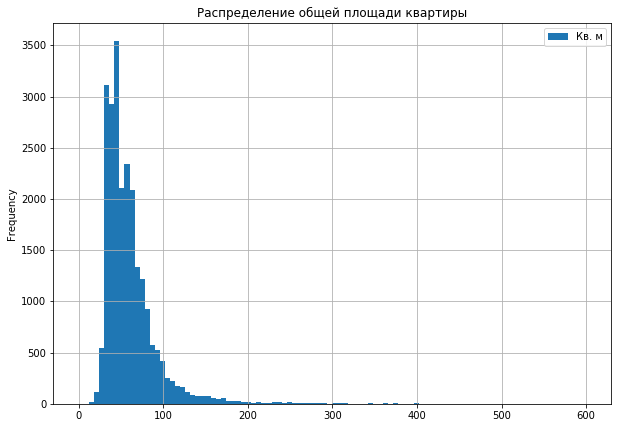

In [41]:
data['total_area'].describe()
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (10,7), range = (0,600), title = 'Распределение общей площади квартиры', label = 'Кв. м')


Ппараметр "цена квартиры" также имеет выборосы со значение более 11 млн руб., которые необходимо удалять.

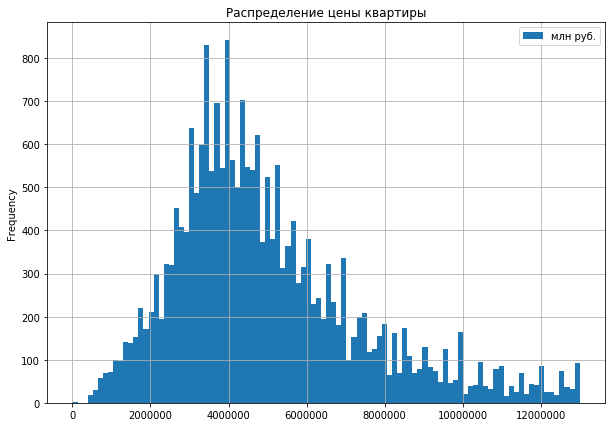

In [40]:
from matplotlib import pyplot as plt
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, figsize = (10,7), range = (0, 13000000), title = 'Распределение цены квартиры', label = 'млн руб.')
plt.ticklabel_format(style='plain')

Как можно увидеть из описательной статистики, распределние также имеет аномальные значения - например, 19 комнат.

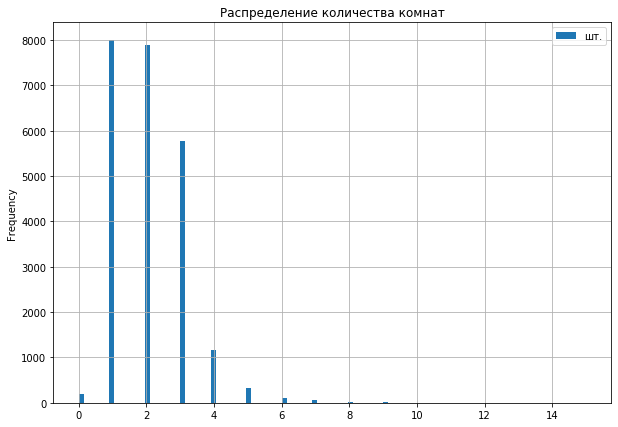

In [43]:
data['rooms'].describe()
data.plot(y = 'rooms', kind = 'hist', bins = 100, grid=True, figsize = (10,7), range = (0, 15), title = 'Распределение количества комнат', label = 'шт.')

Параметр "высота потолков" не имеет выбросов и аномальны значений, так как мы удалили их на этапе предобработки.

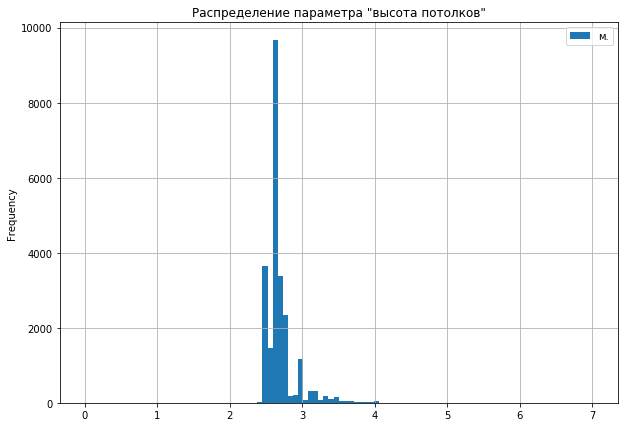

In [44]:
data['ceiling_height'].describe()
data.plot(y = 'ceiling_height', kind = 'hist', bins = 100, grid=True, figsize = (10,7), range = (0, 7),  title = 'Распределение параметра "высота потолков"', label = 'м.')

Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

In [29]:
data['days_exposition'].describe()

count    23608.000000
mean       156.468443
std        213.336064
min          0.000000
25%         22.000000
50%         74.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

В первую очередь определим необычно долгие продажи: как можно увидеть из гистограммы, после 400 дней количество продаж становится более редким, после 600 практически отсутствуют, а после 1000 гистограмма практически сливается с нулем. Среди очень быстрых продаж можно отметить те, которые входят в 25% значений, то есть до 30 дней.

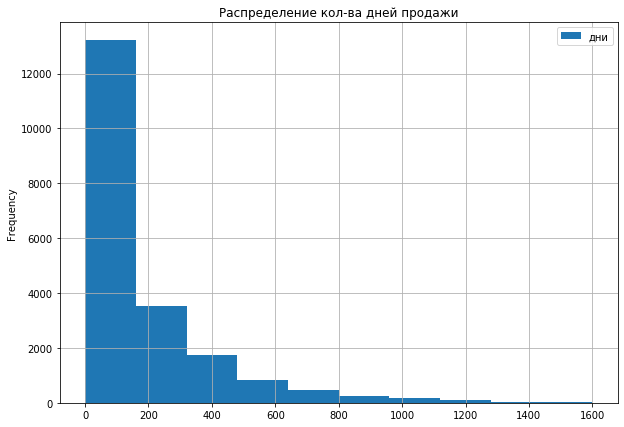

In [45]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 10, grid=True, figsize = (10,7), range = (0, 1600),  title = 'Распределение кол-ва дней продажи', label = 'дни')

Создадим массив с "очищенными" данными от выбросов и аномальных значений. 
Аномальными признаем следующие значения: 
1. в столбце'total_area' - значения, превышающие 140 м2(исходя из графика)
2. в столбце 'last_price' - значения, превышающие 11 млн руб.
3. в столбце, содержащем данные о количестве комнат, - 'rooms', более 5
4. в столбце'ceiling_height' такиз значений больше не обнаружено;
5. в столбце дней продажи'days_exposition' аномальными значениями будут признаны те, которые были совершены менее 30 дней и более 600.

In [31]:
data['wrong_area'] = data['total_area'] > 140
data['wrong_price'] = data['last_price'] > 11000000
data['wrong_ceiling'] = data['ceiling_height'] > 4.0
data['wrong_rooms'] = data['rooms'] > 5
data['too_fast'] = data['days_exposition'] < 30
data['too_slow'] = data['days_exposition'] > 600
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,year,floor_category,area_ratio,kitchen_ratio,wrong_area,wrong_price,wrong_ceiling,wrong_rooms,too_fast,too_slow
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,2019,другой,0.472222,0.231481,False,True,False,False,True,False
1,7,3350000,40,2018-12-04,1,2.60,11,18.6,1,False,...,2018,первый,0.465000,0.275000,False,False,False,False,False,False
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,2015,другой,0.612500,0.148214,False,False,False,False,False,False
3,0,64900000,159,2015-07-24,3,2.60,14,45.0,9,False,...,2015,другой,0.283019,0.062893,True,True,False,False,False,False
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,2018,другой,0.320000,0.410000,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133,2017-03-21,3,3.70,5,73.3,3,False,...,2017,другой,0.551128,0.103985,False,False,False,False,True,False
23695,14,3100000,59,2018-01-15,3,2.65,5,38.0,4,False,...,2018,другой,0.644068,0.144068,False,False,False,False,False,False
23696,18,2500000,56,2018-02-11,2,2.60,3,29.7,1,False,...,2018,первый,0.530357,0.139286,False,False,False,False,True,False
23697,13,11475000,76,2017-03-28,2,3.00,17,30.5,12,False,...,2017,другой,0.401316,0.306579,False,True,False,False,False,True


In [32]:
good_data = data[(data['wrong_area'] == False) & 
     (data['wrong_price'] == False) &
     (data['wrong_rooms'] == False) &
     (data['wrong_ceiling'] == False) &
     (data['too_slow'] == False) &
     (data['too_fast'] == False)].reset_index(drop=True)
good_data
print('Доля "хороших" значений составила: {:.1%}'.format(len(good_data) / len(data)))

Доля "хороших" значений составила: 61.0%


Изучим факторы, больше всего влияющие на стоимость квартиры, построив матрицу корреляций. В первую очередь изучим количественные переменные: площадь, число комнат, удалённость от центра. 
Как можно увидеть, между всеми вышеперечисленными факторами и ценой корреляция в большей степени отрицательная слабая, соответственно, можно говорить о слабой зависимости от вышеперечисленных факторов, однако наибольшее влияние на стоимость оказывает площадь квартиры.

In [33]:
corr = good_data[['price_per_meter',\
           'total_area',\
           'rooms',\
           'cityCenters_nearest']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,price_per_meter,total_area,rooms,cityCenters_nearest
price_per_meter,1,-0.11,-0.25,-0.21
total_area,-0.11,1,0.81,-0.11
rooms,-0.25,0.81,1,-0.079
cityCenters_nearest,-0.21,-0.11,-0.079,1


Следующий шаг посвящен анализу категориальных перменных и зависимости цены от того, на каком этаже расположена квартира: первом, последнем или другом, и от даты размещения: дня недели, месяца и года. Для анализа построим диаграммы размаха:
1. как можно увидеть, для первого и последнего этажа средняя стоимость квадратного метра квартиры несколько ниже, чем для других; при этом квартиры на первом эаже дешевле вне зависимости от месторасположения.
2. день недели и месяц размещения на цену не влияет (цена изменяется в пределах погрешности), в то время как с 2015 г. стоимость растет, как можно увидеть из графика.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


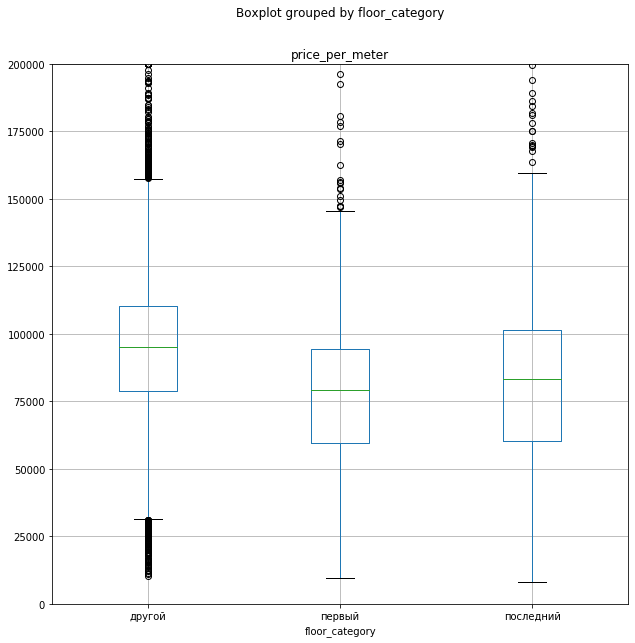

In [34]:
plot_floors = good_data.boxplot('price_per_meter', by='floor_category',figsize=(10,10)).set_ylim(0,200000)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


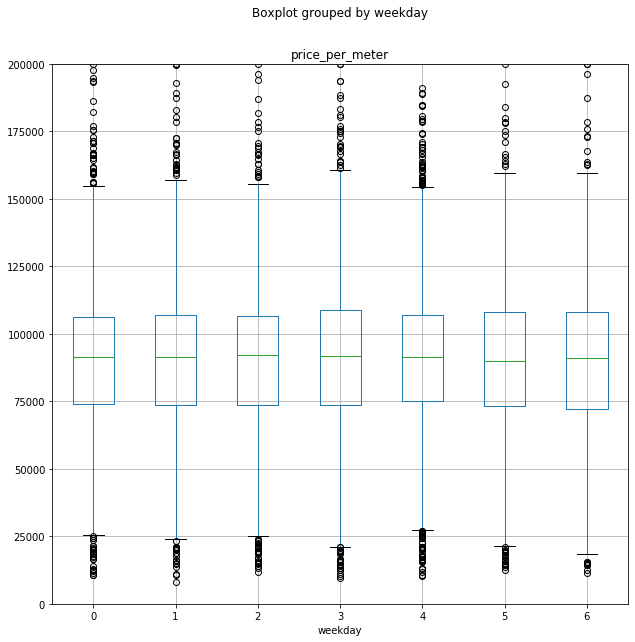

In [35]:
plot_weekday = good_data.boxplot('price_per_meter', by='weekday',figsize=(10,10)).set_ylim(0,200000)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


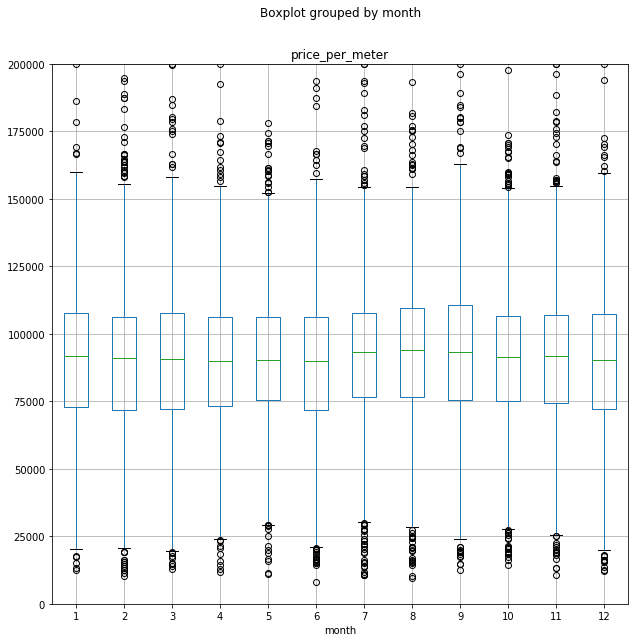

In [36]:
plot_month = good_data.boxplot('price_per_meter', by='month',figsize=(10,10)).set_ylim(0,200000)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


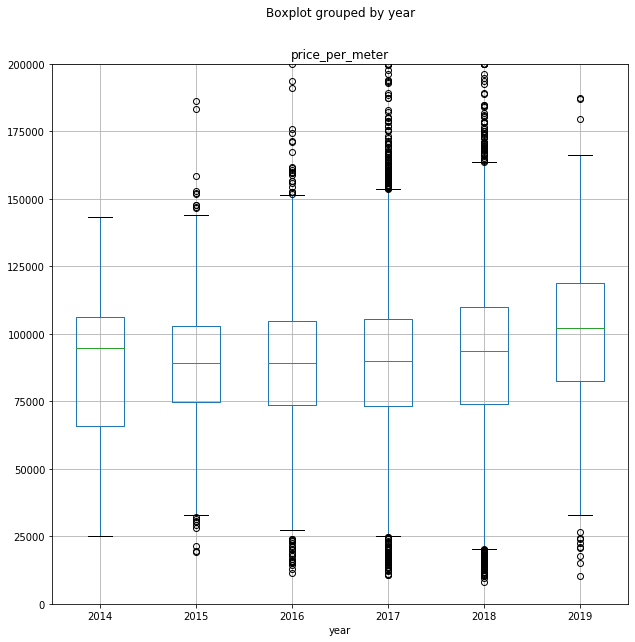

In [37]:
plot_year = good_data.boxplot('price_per_meter', by='year',figsize=(10,10)).set_ylim(0,200000)

Далее выберем 10 населённых пунктов с наибольшим числом объявлений и посчитаем среднюю цену квадратного метра в этих населённых пунктах и выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья. Как можно увидеть ниже, в тройке лидеров по количеству объявлений - Санкт-Петербург, поселок Мурино и поселок Шушары, в то время как по стоимости жилья - Санкт-Петеребург, Пушкин и деревня Кудрово. Наиболее низкая стоимость жилья - во Всеволжске.

In [38]:
top_location = good_data.pivot_table(index='locality_name', values='price_per_meter', aggfunc =['count','median'])
top_location.columns=('count', 'median')
top_location.sort_values(by='count', ascending = False).head(10)

,count,median
locality_name,,
санкт-петербург,8977,101111.0
поселок мурино,416,86410.5
поселок шушары,328,76392.5
всеволожск,280,65843.0
поселок парголово,240,91590.0
колпино,230,73140.5
деревня кудрово,225,92647.0
пушкин,219,97800.0
гатчина,208,67314.0


Изучим предложения квартир и выделим квартиры в Санкт-Петербурге. Для того, чтобы выяснить, какая область входит в центр, построим график, показывающий, как цена зависит от удалённости от центра. Как можно увидеть из графика, резкое падение цены происходит на расстоянии между 5 и 10 км, соответственно, определим центральную зону как то, что находится в радиусе 7 км до центра.

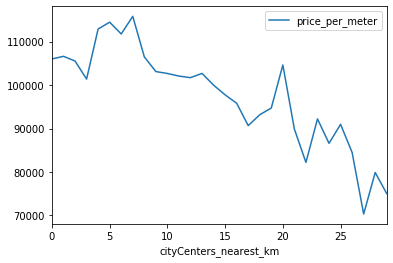

In [39]:
good_data['cityCenters_nearest_km'] = good_data['cityCenters_nearest']/1000
good_data['cityCenters_nearest_km'] = good_data['cityCenters_nearest_km'].astype('int')
data_spb = good_data.query('locality_name in "санкт-петербург"')
data_spb.reset_index(drop=True, inplace=True)
center_km = data_spb.pivot_table(index='cityCenters_nearest_km', values='price_per_meter', aggfunc='median')
center_km.plot()

После того, как мы выделили сегмент квартир в центре, проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Как можно увидеть из графика ниже, "центровой" сегмент отличается большей стоимостью, более высокими потолками и большим количеством комнат.

In [40]:
spb_center = good_data[(good_data['cityCenters_nearest_km'] <= 7) & (good_data['locality_name'] == 'санкт-петербург')]
spb_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,1487.000000,1.487000e+03,1487.000000,1487.000000
mean,63.919301,7.072796e+06,2.271688,2.845393
std,21.419044,1.970786e+06,0.985848,0.297866
min,12.000000,1.800000e+06,0.000000,2.400000
25%,46.000000,5.565396e+06,2.000000,2.650000
50%,62.000000,6.980000e+06,2.000000,2.700000
75%,78.000000,8.500000e+06,3.000000,3.000000
max,139.000000,1.100000e+07,5.000000,4.000000


Кроме того, квартиры в центре имеют более сильную отрицательную взаимосвязь с показателями общей площади и количества комнат, чем в целом по рынку. Наиболее сравнительно низкой остается цена на первый этаж, квартиры, размещенные ближе к выходным (пт, сб и вс), также имеют более высокую стоимость. 

In [41]:
corr = spb_center[['price_per_meter',\
           'total_area',\
           'rooms',\
           'cityCenters_nearest']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,price_per_meter,total_area,rooms,cityCenters_nearest
price_per_meter,1,-0.54,-0.57,0.079
total_area,-0.54,1,0.81,-0.22
rooms,-0.57,0.81,1,-0.18
cityCenters_nearest,0.079,-0.22,-0.18,1


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


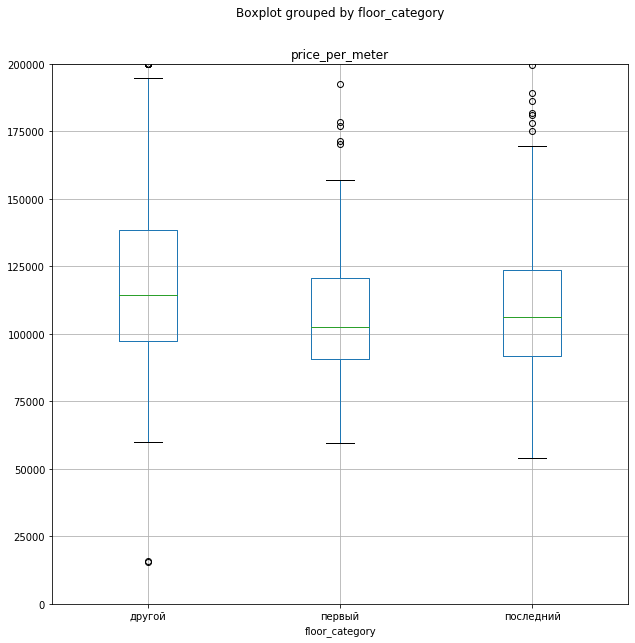

In [42]:
plot_floors = spb_center.boxplot('price_per_meter', by='floor_category',figsize=(10,10)).set_ylim(0,200000)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


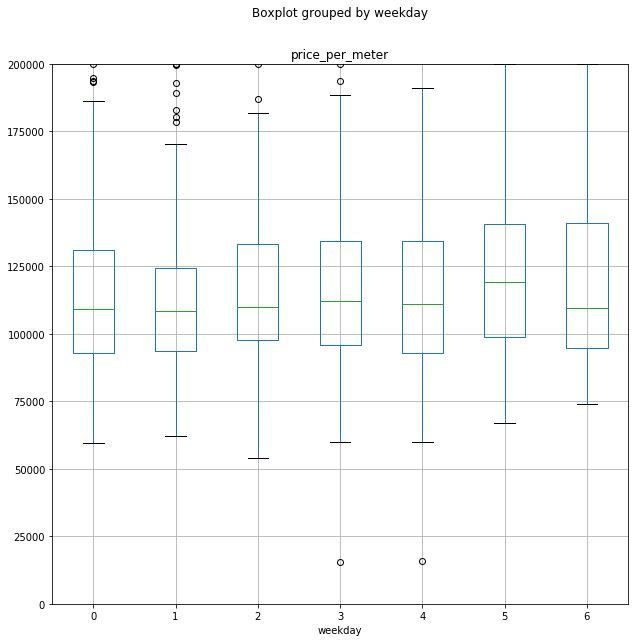

In [43]:
plot_weekday = spb_center.boxplot('price_per_meter', by='weekday',figsize=(10,10)).set_ylim(0,200000)

Стоит сказать, что среди основных отличий центральных квартир - большая площадь, большее количество комнат, более высокие потолки и, соответственно, более высокая стоимость недвижимости.

## Общий вывод

Таким образом, можно сделать следующие выводы: во-первых, на рынке недвижимости имеет место как "подозрительная" активность (квартиры с очень низкими потолками и большим количеством комнат), так и ошибки самих владельцев (потолки вместо 2.7 м 27 м). Во-вторых, наиболее важными для квартир "центрового" сегмента, продающихся по более высокой цене, выступают параметры большей жилой площади и ольшего количества комнат. В-третьих, влияния даты размещения объявления практически отсутсвует, в то время как этаж "другой"(не первый) выступает важным параметром, как и расстояние до центра. В-третьих, наиболее высокой по цене выступает не только недвижимость крупных городов - Санкт-Петербурга и пр., но и пригородов (Пушкин и пр.).